<a href="https://colab.research.google.com/github/Rahafhosari/DataScience2024-2025/blob/master/intro_ml_exam_rahaf_hosari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Machine Learning Exam
Name : Rahaf Hosari

## Mount Drive

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [129]:
#General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
#Column Trasformer & Oipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [131]:
#Classification Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

## Helper Functions

### Classification Helper Function

#### Classification Metrics

In [132]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

#### Calssification Evaluation

In [133]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Load Data

In [134]:
path = '/content/drive/MyDrive/AXSOSACADEMY/02-IntroML/Intro ML Exam/Belt2_C_occupancy_v2_final.csv'
df = pd.read_csv(path)

In [135]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Temperature  1758 non-null   object
 1   Humidity     1208 non-null   object
 2   CO2          1758 non-null   object
 3   IsWeekend    1758 non-null   object
 4   DayOfMonth   1758 non-null   int64 
 5   Occupancy    1758 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 82.5+ KB


,Temperature,Humidity,CO2,IsWeekend,DayOfMonth,Occupancy
0,22.245,Med,Med,Weekday,5,1
1,21.39,High,High,weekday,9,1
2,19_35666667,NaN,Low,Weekday,9,0
3,22.1,NaN,Low,Weekend,7,0
4,21.39,NaN,High,weekday,9,0


First Insights about the Dataset from Info and head:
- Small Data set contains 6 feature columns and 1758 rows.
- There's incosisteny in ['IsWeekend']
- Temperature Column to be converted to Float data type.

From Dictionary
```
Target: Room Occupancy (0 = not occupied, 1 = occupied)
```
```
Temperature in Celsius
```

# EDA : Exploratory Data Analysis

## Duplicates

In [136]:
duplicated_rows = df.duplicated()
duplicated_rows.sum()

18


> There are 18 duplicated rows

### Drop duplicates but keep first occurance

In [137]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

## Null Values
check for null values

In [138]:
df.isna().sum()

,0
Temperature,0
Humidity,545
CO2,0
IsWeekend,0
DayOfMonth,0
Occupancy,0


> Humidity has 545 null values, to be handled with Imputation through model pipelines

## Inconsistency

Convert Temperature to Float

In [139]:
df['Temperature'] = df['Temperature'].astype(float)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1740 entries, 0 to 1757
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  1740 non-null   float64
 1   Humidity     1195 non-null   object 
 2   CO2          1740 non-null   object 
 3   IsWeekend    1740 non-null   object 
 4   DayOfMonth   1740 non-null   int64  
 5   Occupancy    1740 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 95.2+ KB


### Object Columns

In [141]:
categorial_cols = df.select_dtypes(include='object').columns
categorial_cols.values

array(['Humidity', 'CO2', 'IsWeekend'], dtype=object)

#### Check Categorial columns values for Inconsistencies

In [142]:
for column in categorial_cols:
  # print the value counts for the column
  count =  df[column].value_counts().sort_values(ascending=False)
  print(f"Value counts for {column} : {count}")
  print()

Value counts for Humidity : Humidity
Low       427
Med       397
High      343
Hi         10
medium      9
low         9
Name: count, dtype: int64

Value counts for CO2 : CO2
Low     1029
Med      548
High     163
Name: count, dtype: int64

Value counts for IsWeekend : IsWeekend
Weekday    832
Weekend    370
weekday    353
weekend    185
Name: count, dtype: int64



#### Solve Inconsisteny in Humidity

In [143]:
df['Humidity'] = df['Humidity'].replace(to_replace='Hi', value='High')
df['Humidity'] = df['Humidity'].replace(to_replace=['Med','medium'], value='Medium')
df['Humidity'] = df['Humidity'].replace(to_replace='low', value='Low')
df['Humidity'].value_counts()

,count
Humidity,
Low,436
Medium,406
High,353


#### Solve Inconsisteny in CO2

In [144]:
df['CO2'] = df['CO2'].replace(to_replace='Med', value='Medium')
df['CO2'].value_counts()

,count
CO2,
Low,1029
Medium,548
High,163


#### Solve Inconsisteny in IsWeekend

In [145]:
df['IsWeekend'] = df['IsWeekend'].replace(to_replace='weekday', value='Weekday')
df['IsWeekend'] = df['IsWeekend'].replace(to_replace='weekend', value='Weekend')
df['IsWeekend'].value_counts()

,count
IsWeekend,
Weekday,1185
Weekend,555


### Numeric Columns

In [146]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

Index(['Temperature', 'DayOfMonth', 'Occupancy'], dtype='object')

In [147]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1740 entries, 0 to 1757
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  1740 non-null   float64
 1   Humidity     1195 non-null   object 
 2   CO2          1740 non-null   object 
 3   IsWeekend    1740 non-null   object 
 4   DayOfMonth   1740 non-null   int64  
 5   Occupancy    1740 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 95.2+ KB


#### Insights on numerical data using Describe Function

In [148]:
df.describe()

,Temperature,DayOfMonth,Occupancy
count,1.740000e+03,1740.000000,1740.000000
mean,3.627269e+06,6.868966,0.334483
std,8.745429e+07,1.695667,0.471945
min,1.900000e+01,4.000000,0.000000
25%,2.029000e+01,5.000000,0.000000
50%,2.100000e+01,7.000000,0.000000
75%,2.181708e+01,8.000000,1.000000
max,2.242667e+09,10.000000,1.000000


> - From first look no impossible data exist in DayofMonth.
> - In Temperature we can observe a Maximum value of 2.242667e+09 which equals to 2,242,667,000 Celsius, that rather suggest an extremely hot temp that might melt the earth.
Certainly this is an outlier and this temperature is irreleavnt to a room temperature.

> An overview for the data in Tempaerature column, most values of temperature are to the power of +01.
There are other values with +02,+03,+04,+05,+06,+07 and +09, there all indicate extreme impossible values.

>Data conversion error : Assuming there was error in converting data to Celsius, but since we don't know if this hypothesis is true and what might be the temperature the values was converted from.


#### Box Plot

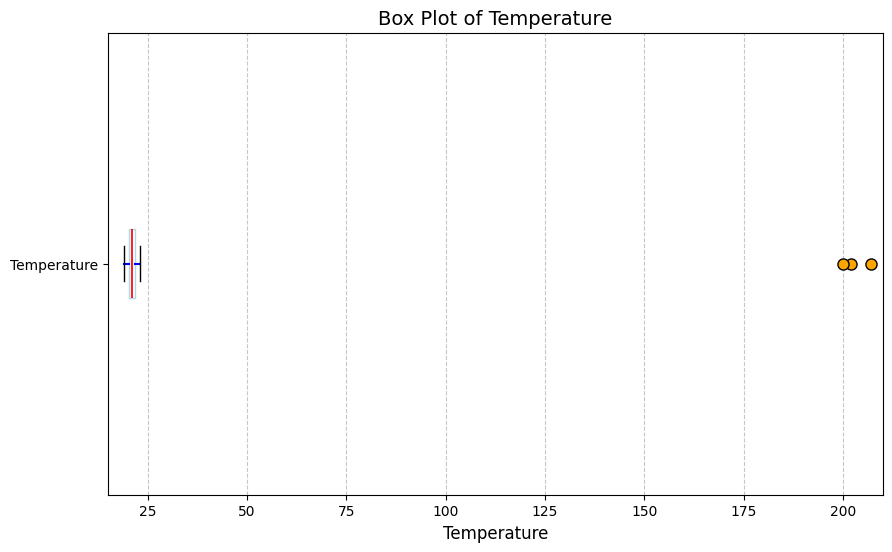

In [149]:
# Box plot for Temperature with visible outliers
plt.figure(figsize=(10, 6))  # For better visibility
box = plt.boxplot(
    df['Temperature'],
    vert=False,
    showmeans=True,
    meanline=True,
    boxprops=dict(color='lightblue'),
    whiskerprops=dict(color='blue', linewidth=1.5),
    medianprops=dict(color='red', linewidth=1.25),
    meanprops=dict(marker='o', markerfacecolor='green', markersize=8),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=8, linestyle='none')
)

plt.title("Box Plot of Temperature", fontsize=14)
plt.xlabel("Temperature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add a grid for x-axis

# Extend the x-axis range to include outliers
plt.xlim([15, 210])  # Adjust to ensure the outlier at 200 is visible
plt.xticks(fontsize=10)
plt.yticks([1], labels=["Temperature"], fontsize=10)  # Add a label for the y-axis
plt.show()

> Using the box plot, we can visualize the existing of very extreme outliers.

#### Histogram

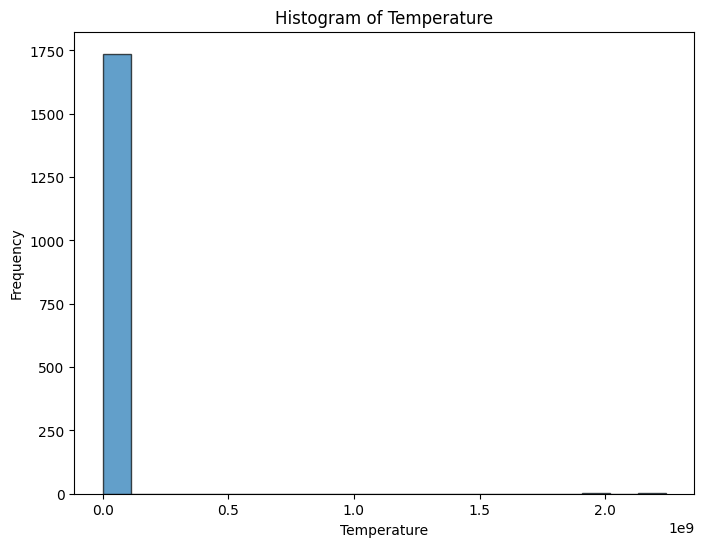

In [150]:
# Histogram for Temperature
plt.figure(figsize=(8, 6))
plt.hist(df['Temperature'], bins=20, edgecolor='k', alpha=0.7)
plt.title("Histogram of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

> Also a plot of the histogram distribution for Temperatures shows the outliers in the Temperature. As we can see there are two small bars to the right at the end of the distribution.

> Looking back at the Describe function values, we observe a clear difference between mean and median, since mean is affected by the extreme outliers.

The values from describe :-
- min 1.900000e+01
- max 2.242667e+09
- mean 3.627269e+06
- median 2.100000e+01


**Imputation Justification** : I will **impute** the **median** for imputation, as it represents 21 Celsius, which is a resonable room temperature.

### Uniqueness

In [170]:
# Percentage of Unique Values in each Column
unique_percentages = df.nunique() / len(df) * 100
unique_percentages.name = 'unique_percentage'
unique_percentages.round(2)
unique_percentages

,unique_percentage
Temperature,15.114943
Humidity,0.172414
CO2,0.172414
IsWeekend,0.114943
DayOfMonth,0.402299
Occupancy,0.114943


> No Highly Unique columns

# Domain Knowledge


> Generally, as temperature increases, the relative humidity decreases. This happens because warmer air can hold more moisture, reducing the relative humidity for a given amount of water vapor.



## Why it's decided **Not** to drop Temperature Column?

> Humidity and temperature together may provide meaningful insights in an office environment, like HVAC system performance, indoor air quality, or occupancy patterns.
Even if Temperature has a weak direct correlation with the target (Occupancy), it might still provide value in combination with Humidity or other variables.

## Handling outliers in Temperature

It is known the ideal room temperature varies vastly depending on the surrounding climate. According to the world health organization the comfortable indoor room temperatures should be 18–24 °C. (source: [Room temperature](https://en.wikipedia.org/wiki/Room_temperature#:~:text=The%20WHO's%202018%20guidelines%20give,general%20populations%20during%20cold%20seasons%22) )

In accordance to the mentioned above and refering to the following article on Meduim
[A Comprehensive Guide to Outliers in Machine Learning: Detection, Handling, and Impact](https://medium.com/@samiraalipour/a-comprehensive-guide-to-outliers-in-machine-learning-detection-handling-and-impact-f7d965bba7a5)

for purposes of better implementation of Machine Learning modeling. I've decided to replace extreme outliers in the temperature with relatable data using the Interquartile Range (IQR).

In [ ]:
#Describe before Replacing Extreme Values
df.describe()

,Temperature,DayOfMonth,Occupancy
count,1.740000e+03,1740.000000,1740.000000
mean,3.627269e+06,6.868966,0.334483
std,8.745429e+07,1.695667,0.471945
min,1.900000e+01,4.000000,0.000000
25%,2.029000e+01,5.000000,0.000000
50%,2.100000e+01,7.000000,0.000000
75%,2.181708e+01,8.000000,1.000000
max,2.242667e+09,10.000000,1.000000


In [171]:
# Calculate IQR
Q1 = df['Temperature'].quantile(0.25).round(2)
Q3 = df['Temperature'].quantile(0.75).round(2)
IQR = (Q3 - Q1).round(2)

# Define lower and upper bounds
lower_bound = (Q1 - 1.5 * IQR).round(2)
upper_bound = (Q3 + 1.5 * IQR).round(2)

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Q1: 20.29
Q3: 21.76
IQR: 1.47
Lower Bound: 18.08
Upper Bound: 23.97


> Values for lowerbound and upperbound are within acceptable range of temperatures.

>Values of temperatures will be checked againsit lowerbound and upperbound.
If lower that 'lowerbound'or if higher than 'upperbound' data will be replaced with median of temperatures.

In [172]:
# Replace extreme values with the median
median_value = df['Temperature'].median()
df.loc[df['Temperature'] < lower_bound, 'Temperature'] = median_value
df.loc[df['Temperature'] > upper_bound, 'Temperature'] = median_value

Confirming change by observing the Descirbe function (or the box plot, note one is enough to verify).
As it can be seen maximum value for is now 23.15 celsuis which is a resonable temperature.

In [173]:
df.describe()

,Temperature,DayOfMonth,Occupancy
count,1740.000000,1740.000000,1740.000000
mean,21.015544,6.868966,0.334483
std,0.974103,1.695667,0.471945
min,19.000000,4.000000,0.000000
25%,20.290000,5.000000,0.000000
50%,21.000000,7.000000,0.000000
75%,21.760000,8.000000,1.000000
max,23.150000,10.000000,1.000000


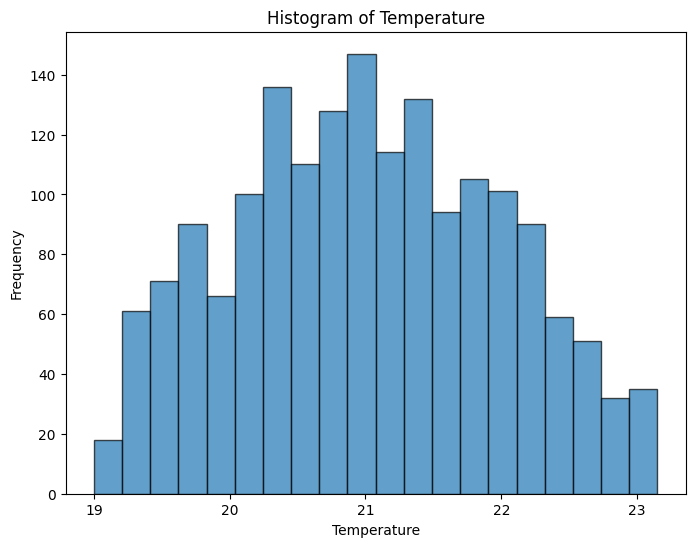

In [174]:
# Histogram for Temperature
plt.figure(figsize=(8, 6))
plt.hist(df['Temperature'], bins=20, edgecolor='k', alpha=0.7)
plt.title("Histogram of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

> Plotting the Histogram we can see data is naturally distributed, and we have a clear historgram of distirbutions.

# Exploratory Visualizations

## Count Plot for Humidity

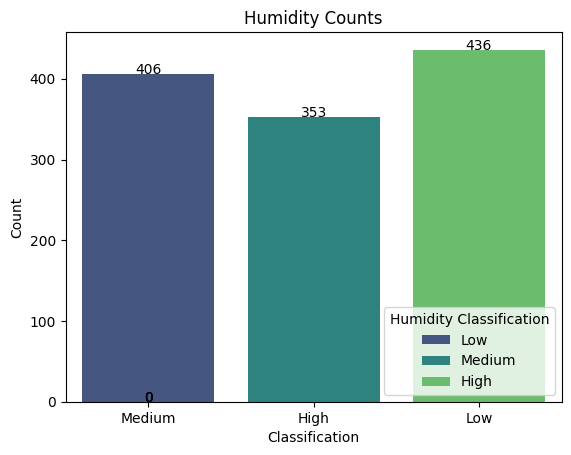

In [175]:
ax = sns.countplot(data=df, x="Humidity",hue="Humidity", palette="viridis")
ax.set_title("Humidity Counts")
ax.set_xlabel("Classification")
ax.set_ylabel("Count")

#Handling Legend Values
legend_labels = ['Low', 'Medium', 'High']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Humidity Classification")

#Annotate Count on Bars
for bar in ax.patches:
    #Count
    count = int(bar.get_height())
    ax.annotate(f'{count}', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',fontsize=10, color='black'
    )

In [153]:
print(df['Humidity'].value_counts(normalize=True))

Humidity
Low       0.364854
Medium    0.339749
High      0.295397
Name: proportion, dtype: float64


>**Impute startegy** for Humidity will be **most_frequent**, it is observed that classes distribution is relatively balanced, meaning percentages are closer to each other. Imputing with most frequent will enusre natural distribution of the data is maintained.

## Heat Map

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

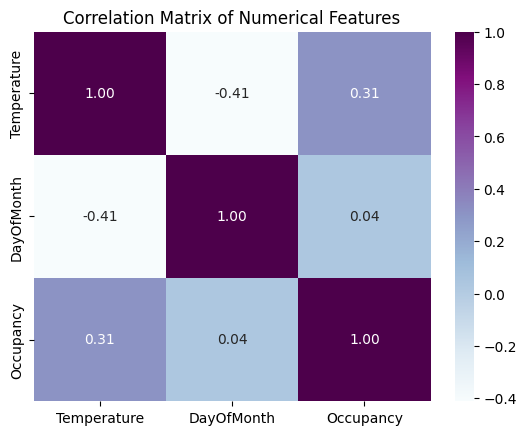

In [177]:
fig, ax = plt.subplots()
ax = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='BuPu',fmt=".2f")
ax.set_title('Correlation Matrix of Numerical Features')

> The correlation matrix heat map shows the correlation between numerical values in the data set.
1. Temperature and Occupancy (0.31) : Inidcates a positive correlation, but an over all weak relationship as the correlation coefficient is closer to zero.
2. Temperature and DayOfMonth (-0.41) : A moderate relation, indicating that as the days in month increases, temperature decrease. This is rather affected by season.
3. DayOfMonth and Occupancy (0.04) : Indicates a very weak correlation.

The heatmap suggests that features are not highly correlated on their own, but might have a weight and effect on Occupancy combined together.

# Modeling

```
Target: Room Occupancy (0 = not occupied, 1 = occupied)
```

## Checking Balance of Target

In [160]:
df['Occupancy'].value_counts()

,count
Occupancy,
0,1158
1,582


In [169]:
(df['Occupancy'].value_counts(normalize=True)*100).round(2)

,proportion
Occupancy,
0,66.55
1,33.45


> Target Data is unbalanced with 66.55% Room Occupancy being not occupied. And a 33.45% being occupied.

## Train Test Split

In [186]:
# Separate X,y and train test split
target = 'Occupancy'
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)  # Ensure stratified split

# Checking the class balance
y_train.value_counts(normalize=True).sort_index()

,proportion
Occupancy,
0,0.665134
1,0.334866


## Model Pipeline

In [188]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1305 entries, 605 to 161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  1305 non-null   float64
 1   Humidity     887 non-null    object 
 2   CO2          1305 non-null   object 
 3   IsWeekend    1305 non-null   object 
 4   DayOfMonth   1305 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 61.2+ KB


### Numerical Columns

In [214]:
numerical_cols = X_train.select_dtypes('number').columns
numerical_cols

Index(['Temperature', 'DayOfMonth'], dtype='object')

#### Scaler

In [215]:
#Scaler
numerical_scaler = StandardScaler()

#### Pipeline

In [216]:
#Display Numerical Pipeline
numerical_pipeline = make_pipeline(numerical_scaler)
numerical_pipeline

Pipeline(steps=[('standardscaler', StandardScaler())])

#### Tuple

In [217]:
#Numerical Columns Tuple
numerical_tuple = ('numerical', numerical_pipeline, numerical_cols)
numerical_tuple

('numerical',
 Pipeline(steps=[('standardscaler', StandardScaler())]),
 Index(['Temperature', 'DayOfMonth'], dtype='object'))

### Categorial Columns (Nominal)

In [218]:
categorial_cols = ['IsWeekend']
categorial_cols

['IsWeekend']

#### One Hot Encode

In [219]:
#OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#### Pipeline

In [220]:
categorial_pipeline = make_pipeline(ohe_encoder)
categorial_pipeline

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

#### Tuple

In [221]:
categorial_tuple = ('categorial', categorial_pipeline, categorial_cols)
categorial_tuple

('categorial',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 ['IsWeekend'])

### Ordinal Columns

In [222]:
ordinal_cols = X_train.select_dtypes('object').columns.drop(categorial_cols)
ordinal_cols

Index(['Humidity', 'CO2'], dtype='object')

#### Simple Imputer (Strategy Most Frequent)

In [223]:
impute_most_frequent = SimpleImputer(strategy='most_frequent')

#### Ordinal Encoder

In [224]:
ordinal_values = ['Low','Medium','High']
ordinal_categories = [ordinal_values]

#Encoder
ord_encoder = OrdinalEncoder(categories=ordinal_categories) # OR ord_encoder = OrdinalEncoder(categories=[ordinal_values])


#### Ordinal Scaler

In [225]:
#Scaler
ord_scaler = StandardScaler()

#### Pipeline

In [226]:
ordinal_pipeline = make_pipeline(impute_most_frequent,ord_encoder,ord_scaler)
ordinal_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Low', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

Tuple

In [227]:
ordinal_tuple = ('ordinal', ordinal_pipeline, ordinal_cols)
ordinal_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Low', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 Index(['Humidity', 'CO2'], dtype='object'))

## Column Transformer

In [228]:
# Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([numerical_tuple,categorial_tuple,ordinal_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Temperature', 'DayOfMonth'], dtype='object')),
                                ('categorial',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['IsWeekend']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Humidity', 'CO2'], dtype='object'))],
                  verbose_feature_names_out=False)

#### Notes on Scaling and Encoding

>StandardScaler standardizes numerical features by removing the mean and scaling them to unit variance. Scaling ensures that all numerical features contribute equally to the model.
Standardization is a type of scaling that involves scaling the values so that the distribution has a standard deviation of 1 and a mean of 0.

> Onehot encoder for nominal values converts these values to machine understandable number.

In case of 'IsWeekend' the column values doesn't have an order.

OneHotEncoder transforms the categories into binary columns, ensuring no artificial ordinal relationship is imposed.This ensures that unknown categories in the test set are handled gracefully without errors.

In [ ]:
> For Ordinal variables like 'Humidity' and 'CO2' they have a meaningful order.
OrdinalEncoder preserves this order by mapping categories to integers (e.g., Low=0, Medium=1, High=2),
which ensures the model captures the ordinal relationship.
Including StandardScaler after the ordinal encoding ensures that these variables are on a comparable scale with other features.


> Imputing missing values with SimpleImputer(strategy='most_frequent') ensures no missing values are passed to the model.

>

#